### The influence of tides in TNBD and DITD Mooring Data 2018 - 2019 

In [75]:
import xarray as xr 
import numpy as np  
import matplotlib.pyplot as plt
import xrft 
import cmocean
import scipy
from scipy.signal import windows
import numpy as np

In [4]:
# load velocity data \Users\mblan\Documents\TNB_Research\data\TNB2018_Raw
# tnbd_vel1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/vel_1100.nc')
# # load sbe data 
# tnbd_sbe1100 = xr.open_dataset('/Users/mackenzie/Documents/Research/PhD/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1100.nc')

# TNBD Data - velocity 
tnbd_vel1100 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/TNB2018_Raw/TNBD/vel_1100.nc')
tnbd_vel1000 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/TNB2018_Raw/TNBD/vel_1000.nc')
# TNBD Data - SBE 
tnbd_sbe1100 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1100.nc')
tnbd_sbe1000 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/TNB2018_Raw/TNBD/sbe_1000.nc')
# DITD Data - velocity 
ditd_vel1100 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/vel_1100.nc')
ditd_vel1200 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/vel_1200.nc')
# DITD Data - SBE 
ditd_sbe1100 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/sbe_1100.nc')
ditd_sbe1200 = xr.open_dataset('/Users/mblan/Documents/TNB_Research/data/DITD_2018_2019/sbe_1200.nc')

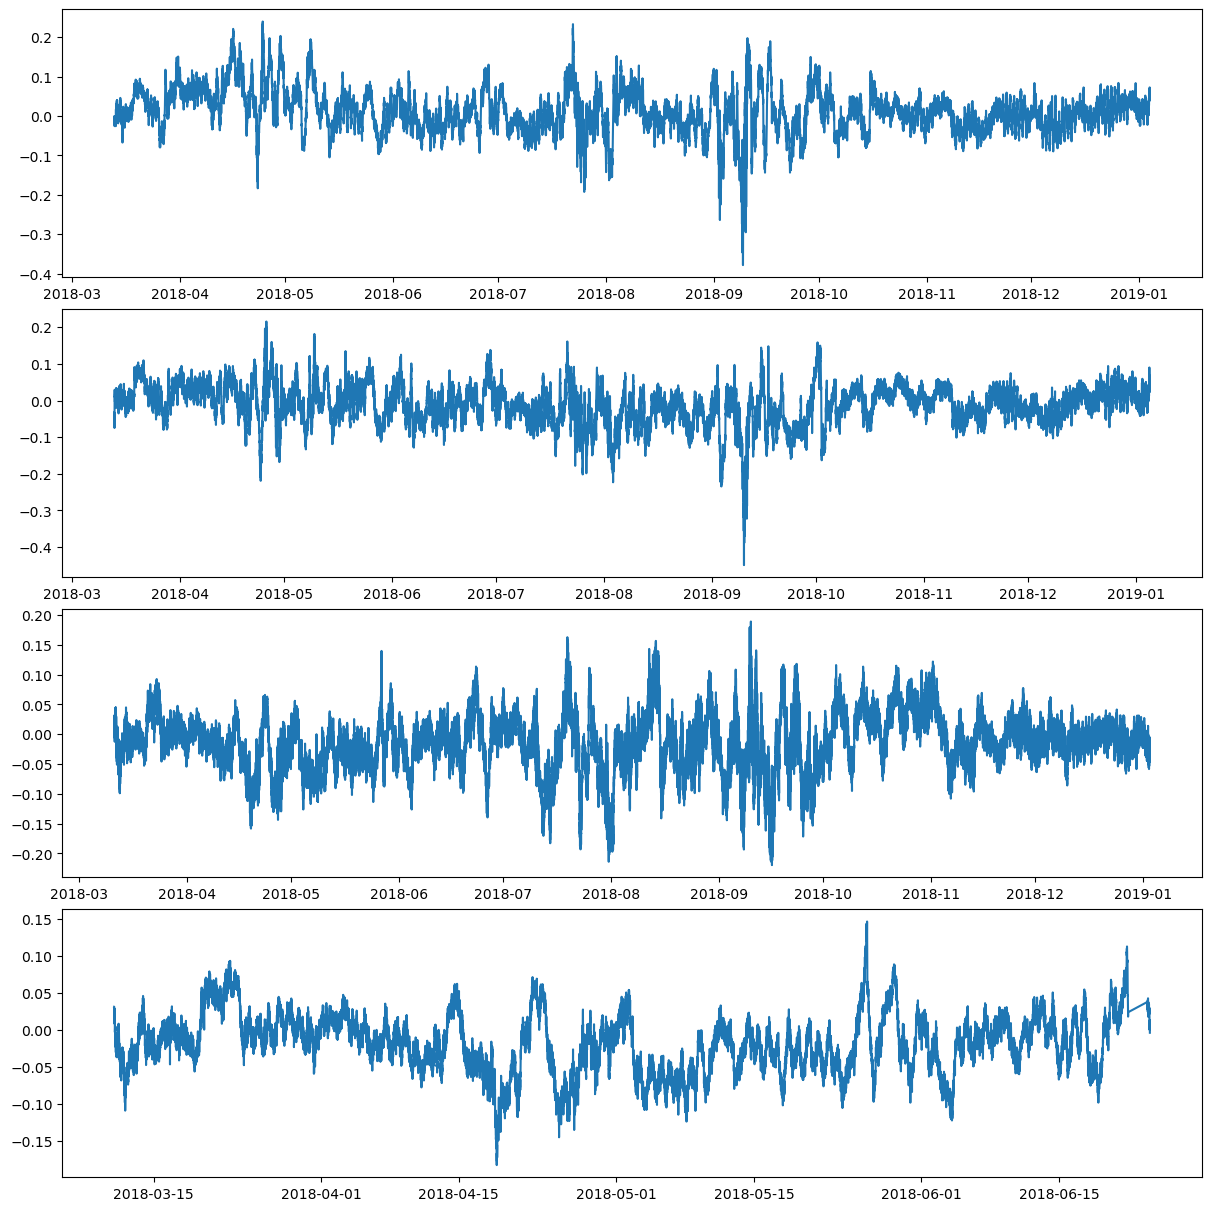

In [11]:
# plot a time series of the velocity data 
fig = plt.figure(figsize=(12,12),constrained_layout=True)
plt.subplot(4,1,1)
plt.plot(tnbd_vel1000.time,tnbd_vel1000.east)

plt.subplot(4,1,2)
plt.plot(tnbd_vel1100.time,tnbd_vel1100.east)

plt.subplot(4,1,3)
plt.plot(ditd_vel1100.time,ditd_vel1100.east)

plt.subplot(4,1,4)
plt.plot(ditd_vel1200.time,ditd_vel1200.east)



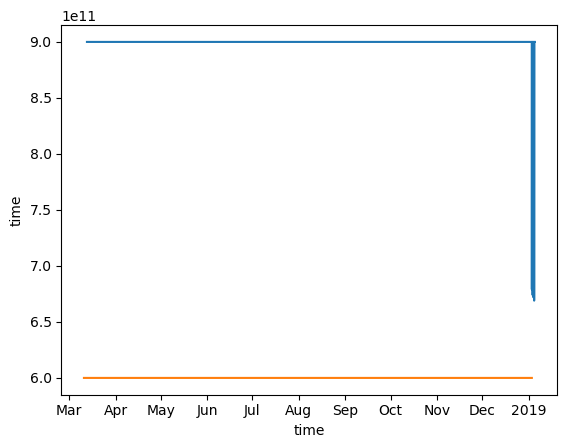

In [13]:
# we need to remove the end of the data because dt gets messed up 
tnbd_vel1100.time.diff('time').plot()
ditd_vel1100.time.diff('time').plot()

In [23]:
tnbd_vel1100 = tnbd_vel1100.sel(time=slice('2018-03','2018-12-31'))
tnbd_sbe1100 = tnbd_sbe1100.sel(time=slice('2018-03','2018-12-31'))

In [22]:
ditd_vel1100 = ditd_vel1100.sel(time=slice('2018-03-13','2018-12-31'))
ditd_sbe1100 = ditd_sbe1100.sel(time=slice('2018-03-13','2018-12-31'))

Note that DITD velocity data is sampled every 10 minutes. TNBD velocity data is every 15 minutes. Will need to interpolate DITD data to same time array as TNBD when doing analysis later. Ok for now while dealing with the datasets seperately

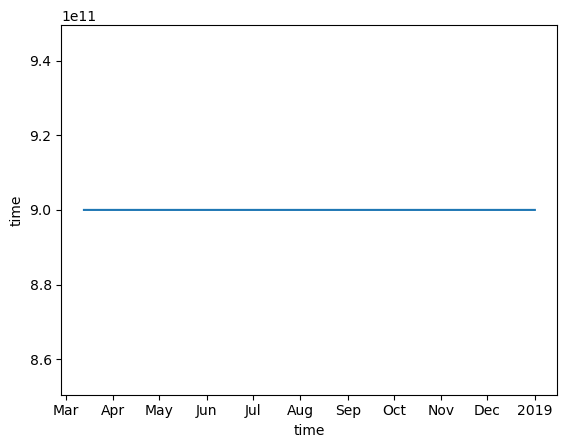

In [26]:
# dt is now the same 
tnbd_vel1100.east.time.diff('time').plot()

In [8]:
# we can see that we have an even number of datapoints - good for FFT 
tnbd_vel1100.east

<xarray.DataArray 'east' (time: 28416)> Size: 227kB
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429],
      shape=(28416,))
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13 ... 2019-01-02T23:45:00

In [27]:
ditd_vel1100.east

<xarray.DataArray 'east' (time: 42336)> Size: 339kB
array([-0.011448, -0.021345, -0.030276, ...,  0.000413, -0.012828, -0.00869 ],
      shape=(42336,))
Coordinates:
    index    (time) int64 339kB ...
  * time     (time) datetime64[ns] 339kB 2018-03-13 ... 2018-12-31T23:50:00

### Spectra using XRFT 

In [28]:
# detrend data 
ditd_east = xrft.detrend(ditd_vel1100.east, dim='time')
ditd_north = xrft.detrend(ditd_vel1100.north, dim='time')

tnbd_east = xrft.detrend(tnbd_vel1100.east, dim='time')
tnbd_north = xrft.detrend(tnbd_vel1100.north, dim='time')


In [30]:
# detrend data 
# east_detrended= xrft.detrend(tnbd_vel1100.east, dim='time')

In [32]:
# calculate spectra 
ditd_east_spectra = xrft.power_spectrum(da=ditd_east.drop_vars(['index']),dim='time')
ditd_north_spectra = xrft.power_spectrum(da=ditd_north.drop_vars(['index']),dim='time')
tnbd_east_spectra = xrft.power_spectrum(da=tnbd_east.drop_vars(['index']),dim='time')
tnbd_north_spectra = xrft.power_spectrum(da=tnbd_north.drop_vars(['index']),dim='time')

In [33]:
# spectra = xrft.power_spectrum(da=east_detrended.drop(['index']),dim='time')

In [34]:
# take only positive part of spectrum 
tnbd_north_spectra = tnbd_north_spectra.where(tnbd_north_spectra.freq_time > 0, drop=True)
tnbd_east_spectra = tnbd_east_spectra.where(tnbd_east_spectra.freq_time > 0, drop=True)
ditd_north_spectra = ditd_north_spectra.where(ditd_north_spectra.freq_time > 0, drop=True)
ditd_east_spectra = ditd_east_spectra.where(ditd_east_spectra.freq_time > 0, drop=True)

In [35]:
# spectra = spectra.where(spectra.freq_time > 0, drop=True)

In [51]:
sampling_rate = 1/600  # 1/minutes 
nyquist = sampling_rate / 2

In [52]:
nyquist

0.0008333333333333334

In [43]:
1/nyquist

30.0

In [45]:
nyquist/3600

9.259259259259259e-06

In [49]:
# output from xrft is in 1/s --> can tell by calculating & comparing with nyquist frequency 
tnbd_north_spectra.freq_time.max()

<xarray.DataArray 'freq_time' ()> Size: 8B
array(0.00055552)

In [50]:
ditd_east_spectra.freq_time.max()

<xarray.DataArray 'freq_time' ()> Size: 8B
array(0.00083329)

In [40]:
# nyquist freq is sampling rate / 2
tnbd_vel1100.east.time.diff(dim='time')

<xarray.DataArray 'time' (time: 28415)> Size: 227kB
array([900000000000, 900000000000, 900000000000, ..., 900000000000,
       900000000000, 900000000000], dtype='timedelta64[ns]')
Coordinates:
    index    (time) int64 227kB ...
  * time     (time) datetime64[ns] 227kB 2018-03-13T00:15:00 ... 2019-01-02T2...

Text(0.5, 1.0, 'DITD Meridional Velocity, 1100 m')

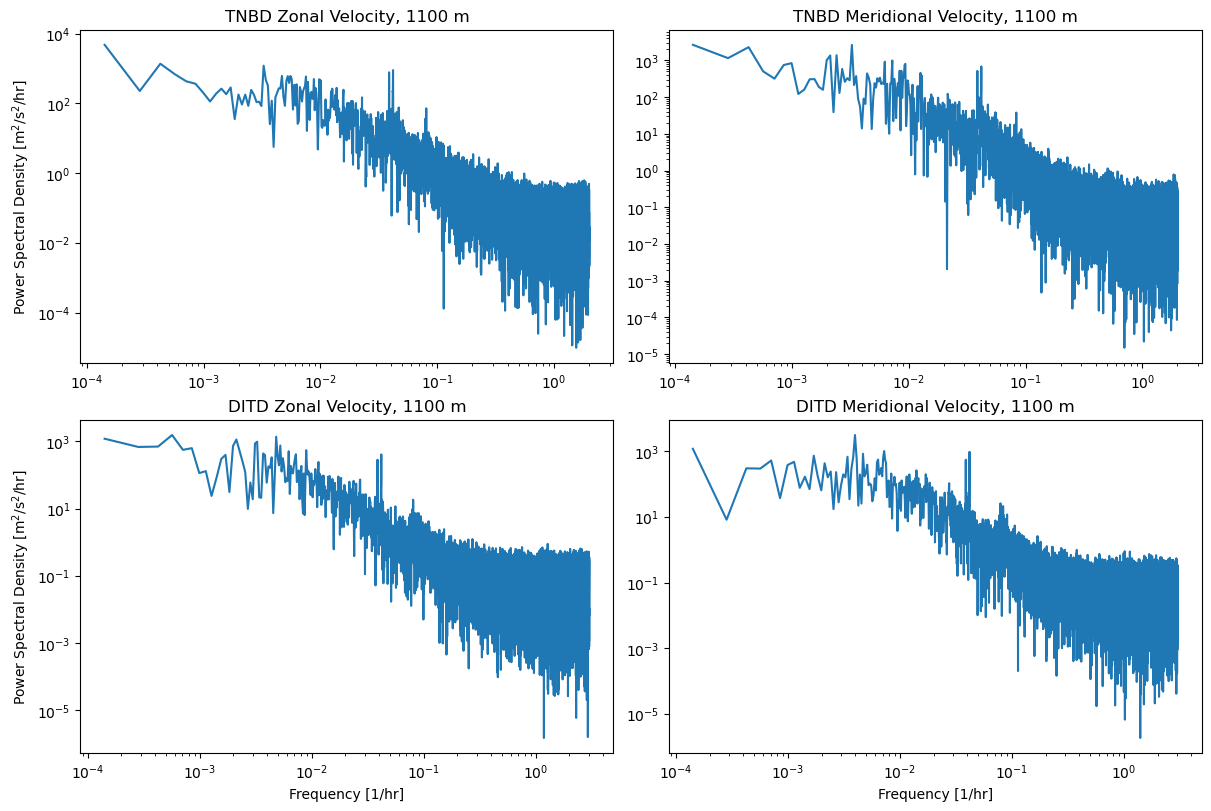

In [72]:
fig = plt.figure(figsize=(12,8),constrained_layout=True)
plt.subplot(2,2,1)
plt.loglog(tnbd_east_spectra.freq_time*3600,tnbd_east_spectra)
plt.ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')
# plt.xlabel('Frequency [1/hr]')
plt.title('TNBD Zonal Velocity, 1100 m')

plt.subplot(2,2,2)
plt.loglog(tnbd_north_spectra.freq_time*3600,tnbd_north_spectra)
# plt.ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')
# plt.xlabel('Frequency [1/hr]')
plt.title('TNBD Meridional Velocity, 1100 m')

plt.subplot(2,2,3)
plt.loglog(ditd_east_spectra.freq_time*3600,ditd_east_spectra)
plt.ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')
plt.xlabel('Frequency [1/hr]')
plt.title('DITD Zonal Velocity, 1100 m')

plt.subplot(2,2,4)
plt.loglog(ditd_north_spectra.freq_time*3600,ditd_north_spectra)
# plt.ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')
plt.xlabel('Frequency [1/hr]')
plt.title('DITD Meridional Velocity, 1100 m')

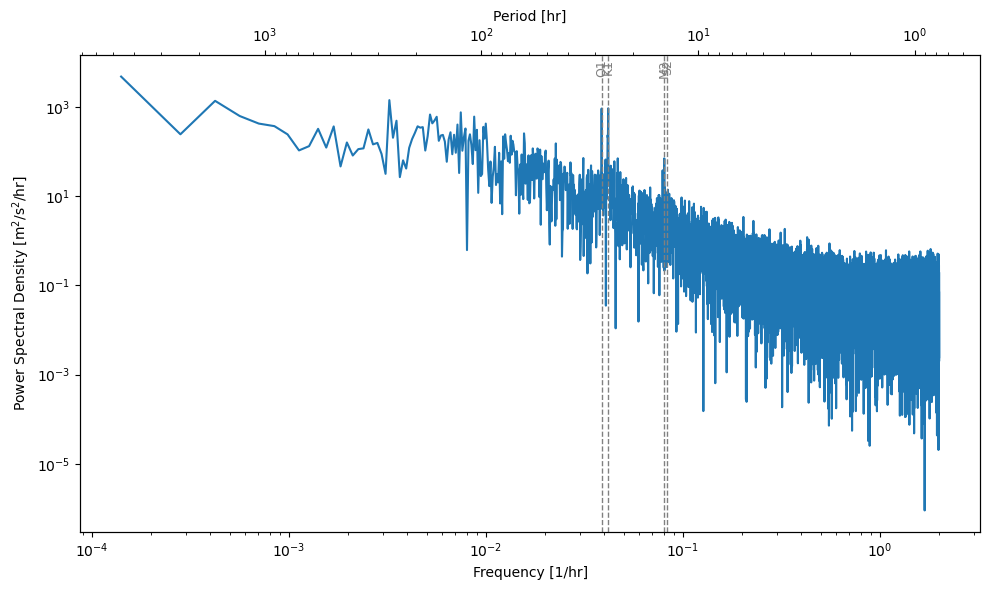

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Frequency and PSD (assumed given)
freq = spectra.freq_time * 3600  # Frequency in 1/hr
psd = spectra

# Create base plot
fig, ax = plt.subplots(figsize=(10,6))
ax.loglog(freq, psd, label='PSD')
ax.set_xlabel('Frequency [1/hr]')
ax.set_ylabel(r'Power Spectral Density [m$^2$/s$^2$/hr]')

# Add vertical shaded regions for tidal peaks
tidal_peaks = {
    'M2': 0.0805,
    'S2': 0.0833,
    'K1': 0.0418,
    'O1': 0.0387
}
# peak_width = 0.002  # Width of shaded region

# for name, f in tidal_peaks.items():
#     ax.axvspan(f - peak_width, f + peak_width, color='gray', alpha=0.3)
#     ax.text(f, ax.get_ylim()[1]*0.8, name, rotation=90,
#             ha='center', va='top', fontsize=9, color='gray')

for name, f in tidal_peaks.items():
    ax.axvline(f, color='gray', linestyle='--', linewidth=1)
    ax.text(f, ax.get_ylim()[1]*0.8, name, rotation=90,
            ha='center', va='top', fontsize=9, color='gray')
    
# Create top x-axis with period
ax_top = ax.twiny()
ax_top.set_xscale('log')

freq_limits = ax.get_xlim()
freq_limits = [spectra.freq_time[0]*3600, spectra.freq_time[-1]*3600]
period_limits = [1/freq_limits[0], 1/freq_limits[1]]
ax_top.set_xlim(period_limits)
ax_top.set_xlabel('Period [hr]')
ax_top.xaxis.set_ticks_position('top')
ax_top.xaxis.set_label_position('top')
# ax_top.ticklabel_format(style='plain', axis='x')

plt.tight_layout()
plt.show()


### Filter out tides 

In this section the goal is to filter out the diurnal tidal signal through the use of a cosine filtering window. 

In [18]:
sampling_hours = 0.25  # sampling period (hrs)
window_days = 3     # desired window 
window_size = int(window_days * 24 / sampling_hours)   # window size based on sampling period 


In [19]:
window_size

288

In [20]:
if window_size % 2 == 0:
    window_size += 1

In [21]:
from scipy.signal import windows
import numpy as np

cosine_window = windows.cosine(window_size)
cosine_window /= cosine_window.sum()  # normalize so it acts like a moving average


In [22]:
len(cosine_window)

289

In [76]:
sampling_hours = 0.25  # sampling period (hrs)
window_days = 3     # desired window 
window_size = int(window_days * 24 / sampling_hours) 

if window_size % 2 == 0:
    window_size += 1

cosine_window = windows.cosine(window_size)
cosine_window /= cosine_window.sum()  # normalize so it acts like a moving average

# assume velocity_da is your DataArray with dimension "time"
cosine_weights = xr.DataArray(cosine_window, dims="window")

# create rolling window and apply weights
tnbd_east_filtered = (
    tnbd_vel1100.east
    .rolling(time=window_size, center=True)
    .construct("window")
    .dot(cosine_weights)
)

tnbd_north_filtered = (
    tnbd_vel1100.north
    .rolling(time=window_size, center=True)
    .construct("window")
    .dot(cosine_weights)
)


In [77]:
sampling_hours = 10/60  # sampling period (hrs)
window_days = 3     # desired window 
window_size = int(window_days * 24 / sampling_hours) 

if window_size % 2 == 0:
    window_size += 1

cosine_window = windows.cosine(window_size)
cosine_window /= cosine_window.sum()  # normalize so it acts like a moving average

# assume velocity_da is your DataArray with dimension "time"
cosine_weights = xr.DataArray(cosine_window, dims="window")

# create rolling window and apply weights
ditd_east_filtered = (
    ditd_vel1100.east
    .rolling(time=window_size, center=True)
    .construct("window")
    .dot(cosine_weights)
)

ditd_north_filtered = (
    ditd_vel1100.north
    .rolling(time=window_size, center=True)
    .construct("window")
    .dot(cosine_weights)
)

Text(0.5, 1.0, 'DITD Meridional')

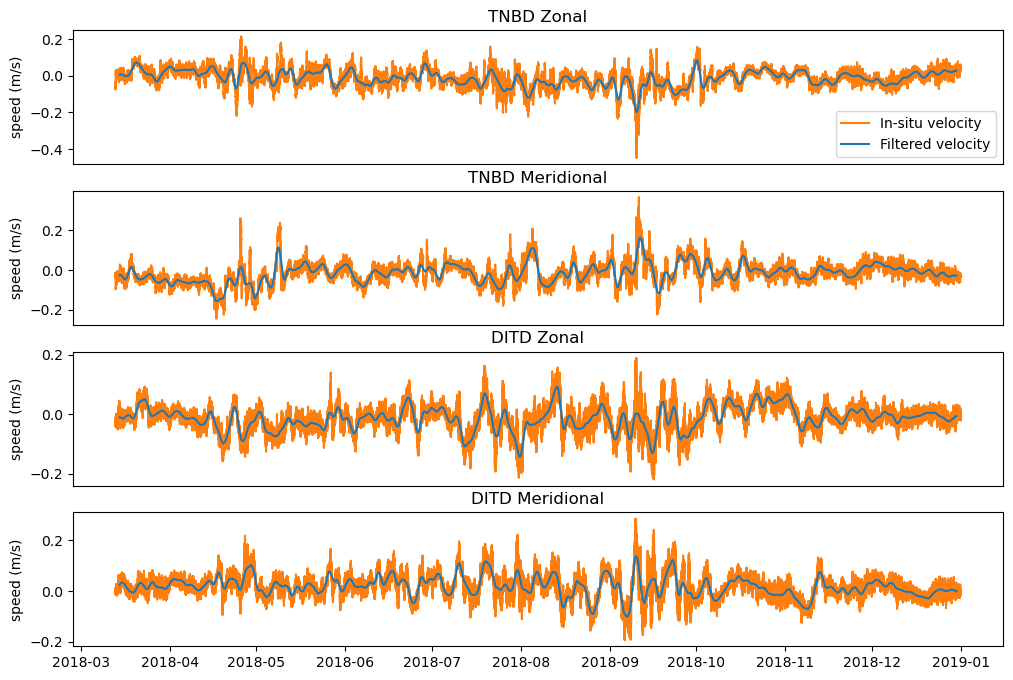

In [82]:
fig = plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
plt.plot(tnbd_vel1100.time,tnbd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_east_filtered.time,tnbd_east_filtered,label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Zonal')
plt.legend()
plt.xticks([])

plt.subplot(4,1,2)
plt.plot(tnbd_vel1100.time,tnbd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_north_filtered.time,tnbd_north_filtered,label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Meridional')
plt.xticks([])

plt.subplot(4,1,3)
plt.plot(ditd_vel1100.time,ditd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_east_filtered.time,ditd_east_filtered,label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.xticks([])
plt.title('DITD Zonal')

plt.subplot(4,1,4)
plt.plot(ditd_vel1100.time,ditd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_north_filtered.time,ditd_north_filtered,label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('DITD Meridional')

In [83]:
# get tidal velocity by subtracting filtered from observed 
tnbd_east_tidal = tnbd_vel1100.east - tnbd_east_filtered
tnbd_north_tidal = tnbd_vel1100.north - tnbd_north_filtered
ditd_east_tidal = ditd_vel1100.east - ditd_east_filtered
ditd_north_tidal = ditd_vel1100.north - ditd_north_filtered


In [90]:
(2880/15)/60

3.2

In [93]:
1440*3/10

432.0

Text(0.5, 1.0, 'DITD Meridional Tides')

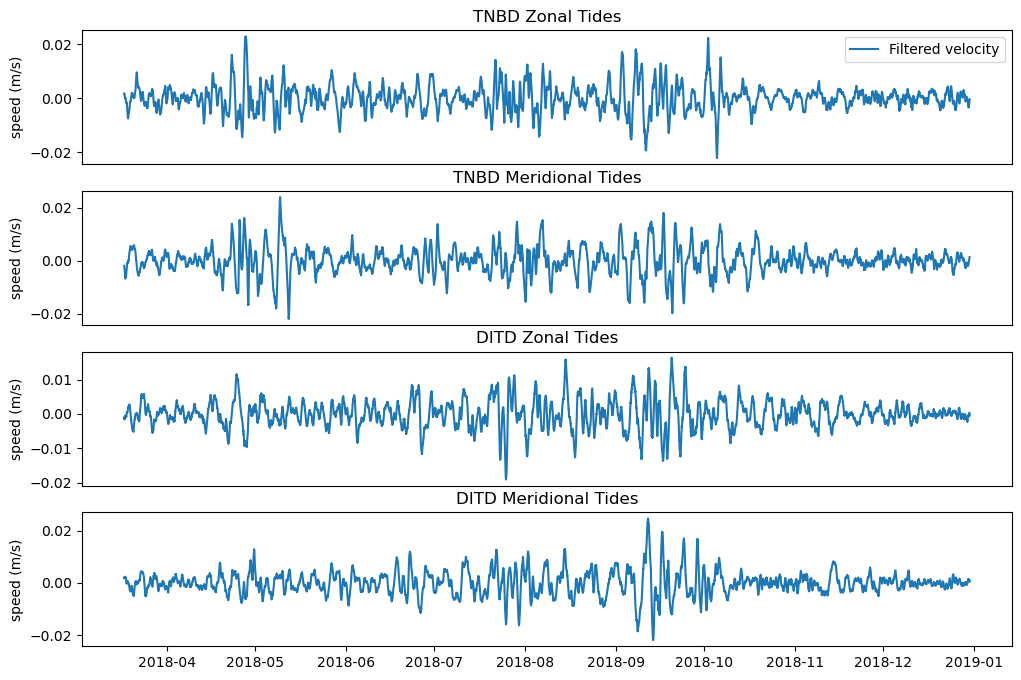

In [94]:
# Plotting with a 3 day rolling average 
fig = plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
# plt.plot(tnbd_vel1100.time,tnbd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_east_tidal.rolling(time=288).mean().time,tnbd_east_tidal.rolling(time=288).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Zonal Tides')
plt.legend()
plt.xticks([])

plt.subplot(4,1,2)
# plt.plot(tnbd_vel1100.time,tnbd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_north_tidal.rolling(time=288).mean().time,tnbd_north_tidal.rolling(time=288).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Meridional Tides')
plt.xticks([])

plt.subplot(4,1,3)
# plt.plot(ditd_vel1100.time,ditd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_east_tidal.rolling(time=432).mean().time,ditd_east_tidal.rolling(time=432).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.xticks([])
plt.title('DITD Zonal Tides')

plt.subplot(4,1,4)
# plt.plot(ditd_vel1100.time,ditd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_north_tidal.rolling(time=432).mean().time,ditd_north_tidal.rolling(time=432).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('DITD Meridional Tides')

In [95]:
# subtract tides from observed velocity 
tnbd_east_detided = tnbd_vel1100.east - tnbd_east_tidal 
tnbd_north_detided = tnbd_vel1100.north - tnbd_north_tidal 

ditd_east_detided = ditd_vel1100.east - ditd_east_tidal 
ditd_north_detided = ditd_vel1100.north - ditd_north_tidal 

Text(0.5, 1.0, 'DITD Meridional Velocity - Tides Removed')

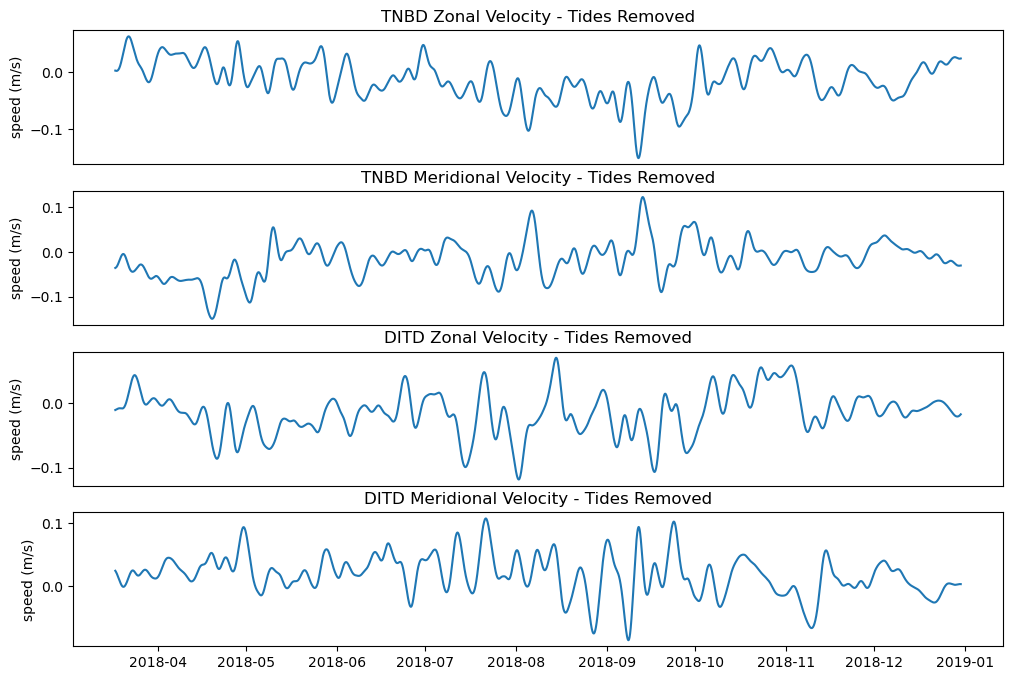

In [105]:
# Plotting with a 3 day rolling average 
fig = plt.figure(figsize=(12,8))
plt.subplot(4,1,1)
# plt.plot(tnbd_vel1100.time,tnbd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_east_detided.rolling(time=288).mean().time,tnbd_east_detided.rolling(time=288).mean(),label='Filtered velocity')
# plt.plot(tnbd_east_filtered.rolling(time=288).mean().time,tnbd_east_filtered.rolling(time=288).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Zonal Velocity - Tides Removed')
# plt.legend()
plt.xticks([])

plt.subplot(4,1,2)
# plt.plot(tnbd_vel1100.time,tnbd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(tnbd_north_detided.rolling(time=288).mean().time,tnbd_north_detided.rolling(time=288).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('TNBD Meridional Velocity - Tides Removed')
plt.xticks([])

plt.subplot(4,1,3)
# plt.plot(ditd_vel1100.time,ditd_vel1100.east,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_east_detided.rolling(time=432).mean().time,ditd_east_detided.rolling(time=432).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.xticks([])
plt.title('DITD Zonal Velocity - Tides Removed')

plt.subplot(4,1,4)
# plt.plot(ditd_vel1100.time,ditd_vel1100.north,color='tab:orange',label='In-situ velocity')
plt.plot(ditd_north_detided.rolling(time=432).mean().time,ditd_north_detided.rolling(time=432).mean(),label='Filtered velocity')
plt.ylabel('speed (m/s)')
plt.title('DITD Meridional Velocity - Tides Removed')

In [99]:
# calculate velocity magnitude 
tnbd_vel_mag = np.sqrt(tnbd_east_detided**2 + tnbd_north_detided**2)
ditd_vel_mag = np.sqrt(ditd_east_detided**2 + ditd_north_detided**2)

Text(0.5, 1.0, 'Velocity Magnitude at TNBD and DITD - Detided')

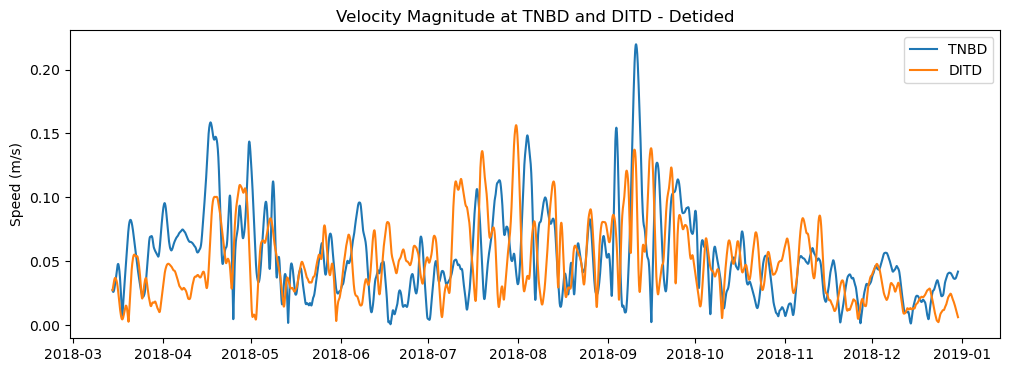

In [102]:
fig = plt.figure(figsize=(12,4))
plt.plot(tnbd_vel_mag.time,tnbd_vel_mag,label='TNBD')
plt.plot(ditd_vel_mag.time,ditd_vel_mag,label='DITD')
plt.legend()
plt.ylabel('Speed (m/s)')
plt.title('Velocity Magnitude at TNBD and DITD - Detided')

Text(0.5, 1.0, 'Velocity Magnitude at TNBD and DITD - Detided')

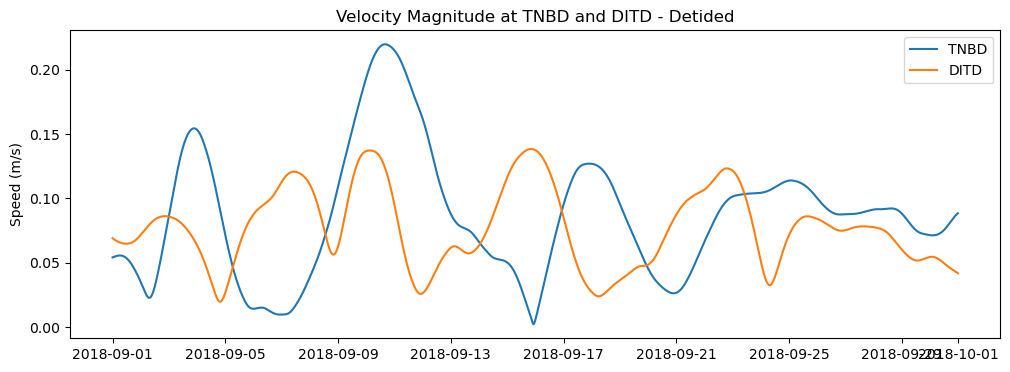

In [103]:
fig = plt.figure(figsize=(12,4))
plt.plot(tnbd_vel_mag.sel(time=slice('2018-09-01','2018-09-30')).time,tnbd_vel_mag.sel(time=slice('2018-09-01','2018-09-30')),label='TNBD')
plt.plot(ditd_vel_mag.sel(time=slice('2018-09-01','2018-09-30')).time,ditd_vel_mag.sel(time=slice('2018-09-01','2018-09-30')),label='DITD')
plt.legend()
plt.ylabel('Speed (m/s)')
plt.title('Velocity Magnitude at TNBD and DITD - Detided')

In [131]:
# fig = plt.figure(figsize=(12,4))
# plt.plot(tidal.rolling(time=2880).mean().time,tidal.rolling(time=2880).mean())
# plt.plot(tnbd_sbe1100.rolling(time=

In [130]:
# plt.plot(tidal.resample(time='30D').mean().time,tidal.resample(time='30D').mean())

### Compare tides with SBE data 

In [106]:
# calculate tidal magnitude 
ditd_tides = np.sqrt(ditd_east_tidal**2 + ditd_north_tidal**2)
tnbd_tides = np.sqrt(tnbd_east_tidal**2 + tnbd_north_tidal**2)


Text(0, 0.5, 'Speed (m/s)')

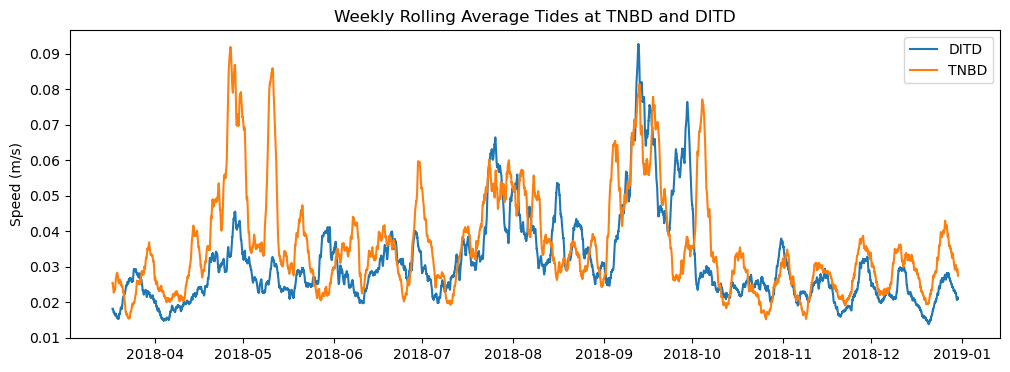

In [112]:
fig = plt.figure(figsize=(12,4))
plt.plot(ditd_tides.rolling(time=432).mean().time,ditd_tides.rolling(time=432).mean(),label='DITD')
plt.plot(tnbd_tides.rolling(time=288).mean().time,tnbd_tides.rolling(time=288).mean(),label='TNBD')
plt.legend()
plt.title('Weekly Rolling Average Tides at TNBD and DITD')
plt.ylabel('Speed (m/s)')

In [116]:
ditd_sbe1100

<xarray.Dataset> Size: 27MB
Dimensions:             (time: 423360)
Coordinates:
    index               (time) int64 3MB ...
  * time                (time) datetime64[ns] 3MB 2018-03-13T00:00:01 ... 201...
Data variables:
    temp                (time) float64 3MB ...
    pressure            (time) int64 3MB ...
    absolute_salinity   (time) float64 3MB ...
    conservative_temp   (time) float64 3MB ...
    density             (time) float64 3MB ...
    practical_salinity  (time) float64 3MB ...

In [118]:
ditd_temp_weekly = ditd_sbe1100.rolling(time=10080).mean().temp

In [126]:
10080/3

3360.0

In [128]:
tnbd_temp_weekly = tnbd_sbe1100.rolling(time=3360).mean().temp

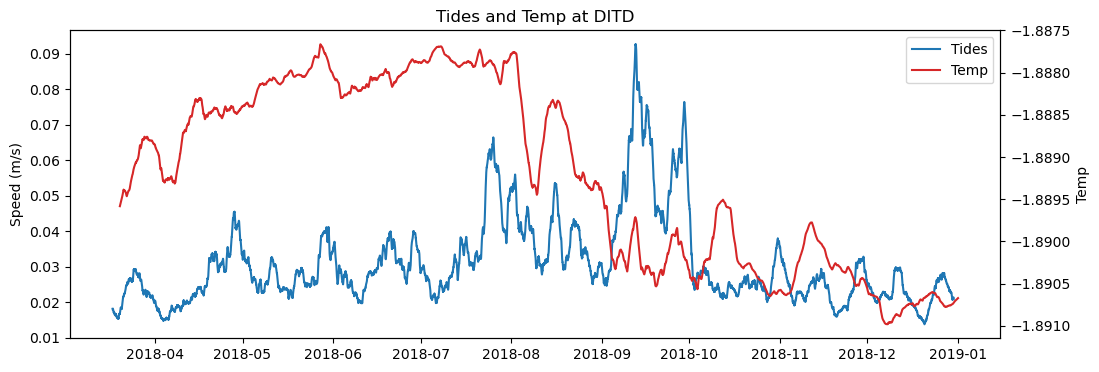

In [124]:
# 10080
fig, ax = plt.subplots(figsize=(12,4))
line, = ax.plot(ditd_tides.rolling(time=432).mean().time,ditd_tides.rolling(time=432).mean(),label='Tides')
ax.set_ylabel('Speed (m/s)')

# twin x
ax1 = ax.twinx()
line1, = ax1.plot(ditd_temp_weekly.time,ditd_temp_weekly,color='tab:red',label='Temp')
ax1.set_ylabel('Temp')

ax.set_title('Tides and Temp at DITD')

lines = [line, line1]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)


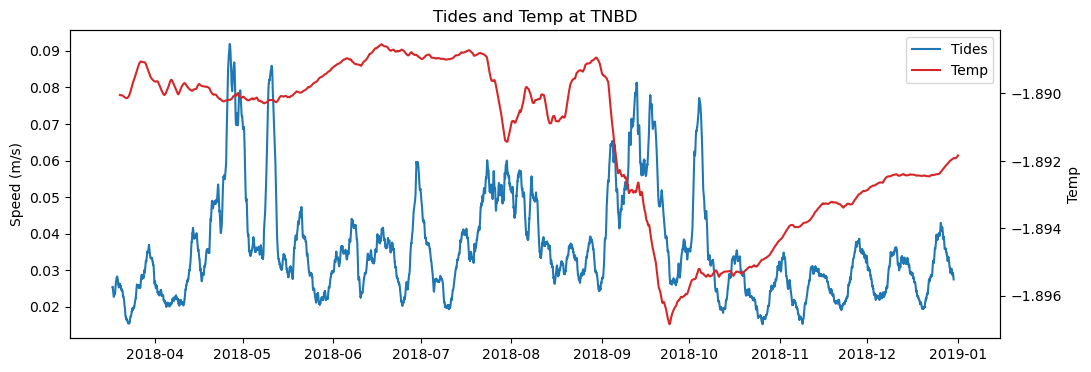

In [129]:
# 10080
fig, ax = plt.subplots(figsize=(12,4))
line, = ax.plot(tnbd_tides.rolling(time=288).mean().time,tnbd_tides.rolling(time=288).mean(),label='Tides')
ax.set_ylabel('Speed (m/s)')

# twin x
ax1 = ax.twinx()
line1, = ax1.plot(tnbd_temp_weekly.time,tnbd_temp_weekly,color='tab:red',label='Temp')
ax1.set_ylabel('Temp')

ax.set_title('Tides and Temp at TNBD')

lines = [line, line1]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)

### FFT Analysis via numpy 

In [40]:
fh = scipy.fft.rfft(east_detrend)

In [41]:
freq = scipy.fft.rfftfreq(n=len(east_detrend),d=15)

In [43]:
len(freq)

14209

In [44]:
len(fh)

14209

/opt/anaconda3/envs/oceandynamics/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


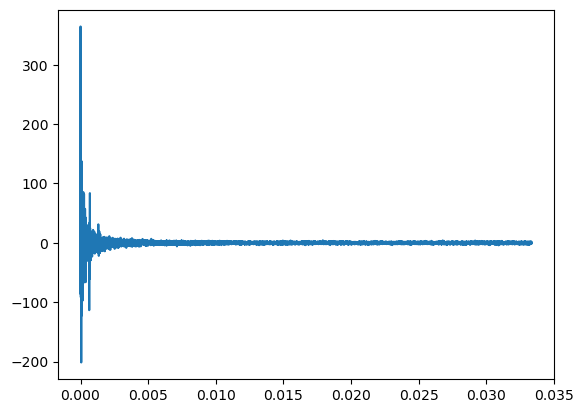

In [45]:
plt.plot(freq,fh)

In [46]:
magnitude_spectrum = np.abs(fh)

In [48]:
len(magnitude_spectrum )

14209

(0.001, 10000.0)

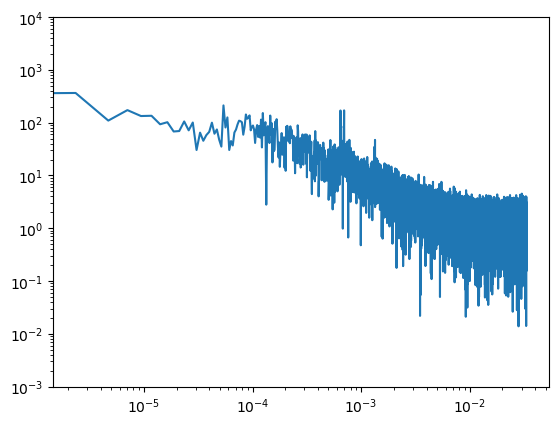

In [83]:
plt.loglog(freq,magnitude_spectrum)
# plt.xlim(-0.00001,0.005)
plt.ylim(10e-4,10e3)

In [54]:
from scipy.signal import butter, lfilter

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [55]:
# Sample rate and desired cutoff frequencies (in Hz).
fs = 1/15
lowcut = 0.0006
highcut = 0.0008


In [57]:
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

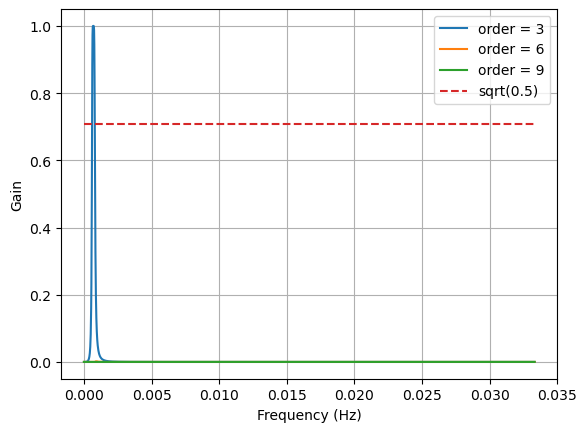

In [58]:
# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')

In [59]:
y = butter_bandpass_filter(east_detrend, lowcut, highcut, fs, order=3)

In [71]:
y

array([-3.68029161e-08, -2.65754611e-07, -9.69070453e-07, ...,
        1.08600076e-02,  1.07535625e-02,  1.05869719e-02])

In [75]:
east_detrend[0:30]

array([-0.04479367, -0.05695182, -0.05066   , -0.03110021, -0.04329592,
       -0.05650989, -0.053326  , -0.06265822, -0.06094682, -0.07097771,
       -0.07439805,  0.02372985,  0.02203571,  0.00966143,  0.02456567,
        0.03001781,  0.00999909,  0.02094646,  0.02733537,  0.01012062,
        0.01179446,  0.01302968, -0.00295068,  0.00172765,  0.01898162,
        0.0074031 ,  0.00579044,  0.00634893,  0.01156298,  0.00814264])

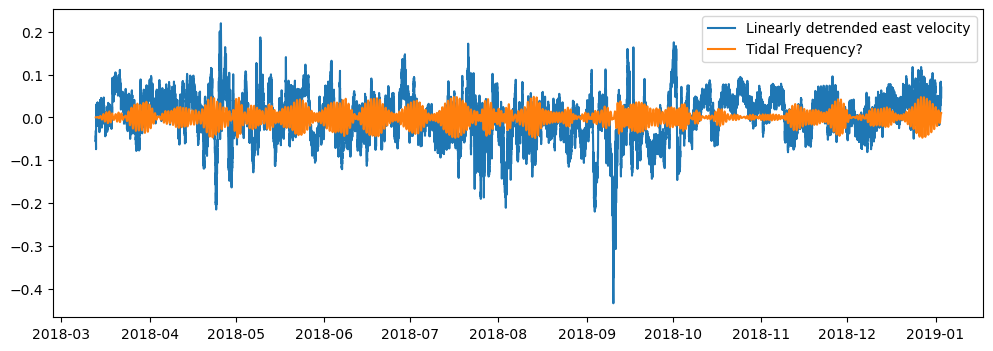

In [80]:
fig = plt.figure(figsize=(12,4))
plt.plot(east.time,east_detrend,label='Linearly detrended east velocity')
plt.plot(east.time,y,label='Tidal Frequency?')
# plt.plot(east.isel(time=slice(0,1000)).time,(east_detrend - y)[0:1000],label='velocity - tidal frequency')
plt.legend()

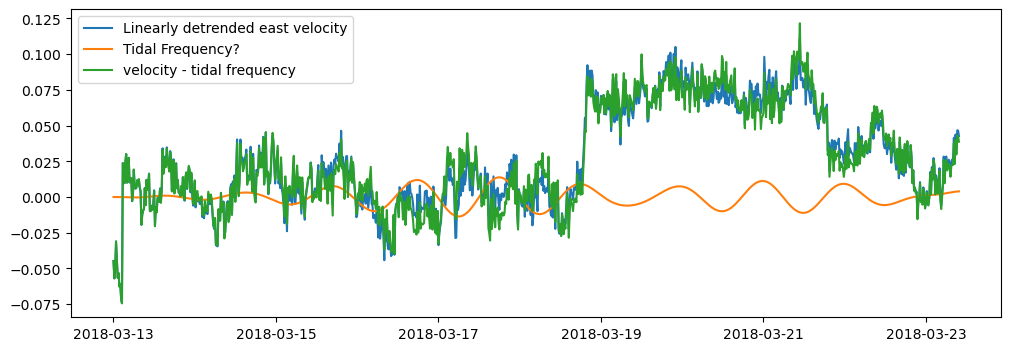

In [79]:
fig = plt.figure(figsize=(12,4))
plt.plot(east.isel(time=slice(0,1000)).time,east_detrend[0:1000],label='Linearly detrended east velocity')
plt.plot(east.isel(time=slice(0,1000)).time,y[0:1000],label='Tidal Frequency?')
plt.plot(east.isel(time=slice(0,1000)).time,(east_detrend - y)[0:1000],label='velocity - tidal frequency')
plt.legend()

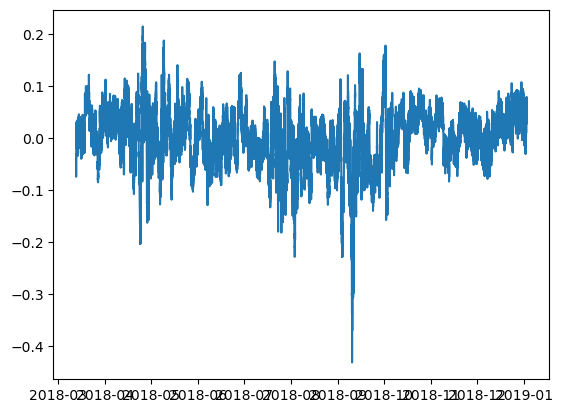

In [67]:
plt.plot(east.time,(east_detrend - y))

In [44]:
# east.time.diff(dim='time')[0].values.astype('float64')

900000000000.0

In [14]:
inverse_sample_rate = 1/east.time.diff(dim='time')[0].values.astype('float64')

In [15]:
inverse_sample_rate

1.1111111111111112e-12

In [16]:
fh = np.fft.rfft(east_detrend)

In [35]:
len(fh.real)

14209

In [19]:
#If n is even, the length of the transformed axis is (n/2)+1
len(fh)

14209

In [23]:
dt = 15
N = len(east_detrend)
scale = 1/(N*dt)

In [24]:
N*dt

426240

In [25]:
scale

2.346096096096096e-06

In [27]:
delta_f = scale 

In [28]:
freq = delta_f * np.arange(N)

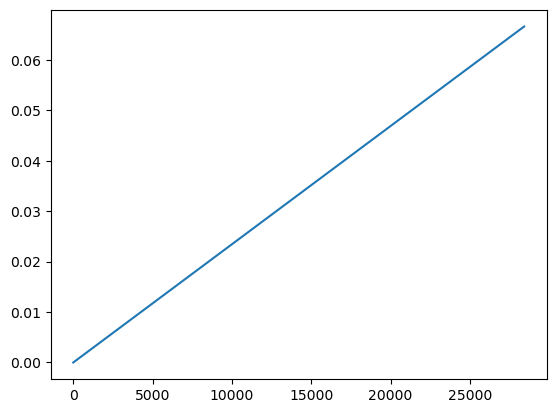

In [30]:
plt.plot(freq)

In [31]:
# only positive 
freq_pos = delta_f * np.arange(((N/2)+1))

In [36]:
len(freq_pos)

14209

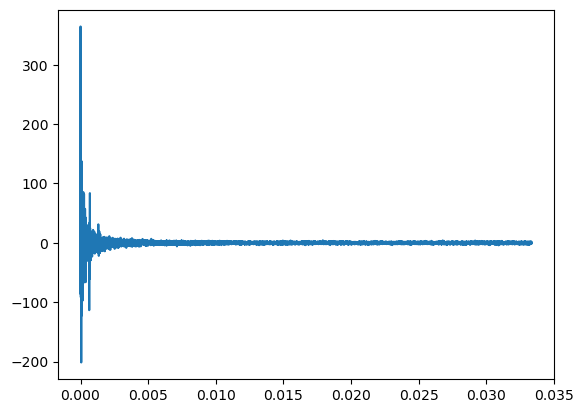

In [37]:
plt.plot(freq_pos,fh.real)

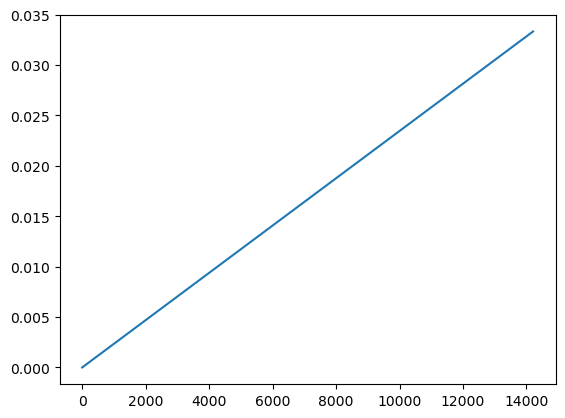

In [32]:
plt.plot(freq_pos)

In [ ]:
fh = 

In [26]:
freq*scale

NameError: name 'freq' is not defined

In [98]:
# calculate frequencies associated with rfft 
freq = np.fft.rfftfreq(n=len(east_detrend),d=1/15)

In [99]:
# length matches that of fft 
len(freq)

14209

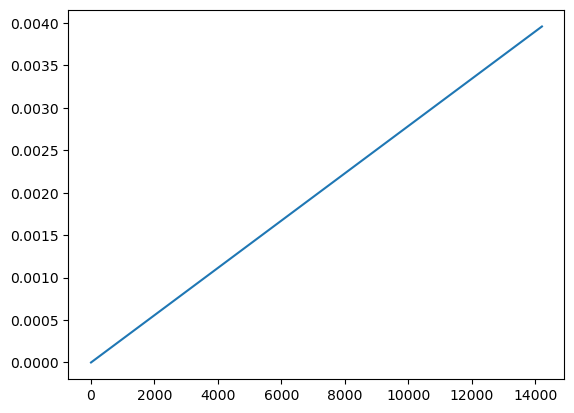

In [100]:
plt.plot(freq*scale)

In [101]:
(freq*scale).max()

0.0039590371621621625

In [102]:
(freq*scale).min()

0.0

In [70]:
time_strings = east.time.values

In [71]:
time_strings

array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ...,
       '2019-01-02T23:15:00.000000000', '2019-01-02T23:30:00.000000000',
       '2019-01-02T23:45:00.000000000'], dtype='datetime64[ns]')

In [72]:
T = (time_strings[-1] - time_strings[0]).astype('timedelta64[m]')

In [73]:
T

numpy.timedelta64(426225,'m')

In [74]:
T = 426225  #minutes 

In [75]:
delta_t = 15   # minutes 

In [76]:
sample_intervals = T/delta_t

In [77]:
sample_intervals

28415.0

In [78]:
# sample points 
N = sample_intervals + 1 

In [79]:
N

28416.0

In [80]:
nyquist_freq = 1/(2*delta_t)

In [81]:
nyquist_freq

0.03333333333333333

In [82]:
(sample_intervals/2)/(sample_intervals*delta_t)

0.03333333333333333

In [83]:
# our max freq is nyquist frequency 
# our min freq is 1/Time_length 
1/T

2.3461786615050735e-06

In [84]:
freq

array([0.00000000e+00, 5.27871622e-04, 1.05574324e-03, ...,
       7.49894426e+00, 7.49947213e+00, 7.50000000e+00])

In [31]:
N = len(east_detrend)
dt = 1/15
# define scaling factor 
scale = 1/(N*dt)

In [32]:
# get spectrum by taking the real part of FFT 
spec = 2*(fh*fh.conj()).real / scale / N**2

# account for zeroth frequency 
spec[0] = spec[0]/2

In [33]:
len(spec)

14209

In [13]:
plt.plot(freq*sacle,spec)

NameError: name 'freq' is not defined

In [163]:
u_dft = xrft.dft(east, true_phase=True, true_amplitude=True, detrend='constant',window='hamming')

/opt/anaconda3/envs/oceandynamics/lib/python3.10/site-packages/xrft/xrft.py:248: FutureWarning: This function has been renamed and will disappear in the future. Please use `fft` instead
  warnings.warn(msg, FutureWarning)


In [164]:
u_dft_real = u_dft.real.where(u_dft.real > 0, drop=True)
# u_dft_real = u_dft.real.where(u_dft.real > 0, drop=True)

In [165]:
u_dft_real = u_dft_real.where(u_dft.freq_time > 0, drop=True)

In [166]:
u_dft_real['freq_time'] = u_dft_real.freq_time*(60/1)

In [167]:
u_dft_real

<xarray.DataArray (freq_time: 7145)>
array([124165.88396845,  22719.19210515,   8450.41280674, ...,
          228.29785624,   1032.38976226,    202.8042837 ])
Coordinates:
  * freq_time  (freq_time) float64 2.346e-06 4.692e-06 ... 0.03332 0.03333

(0.0, 0.005)

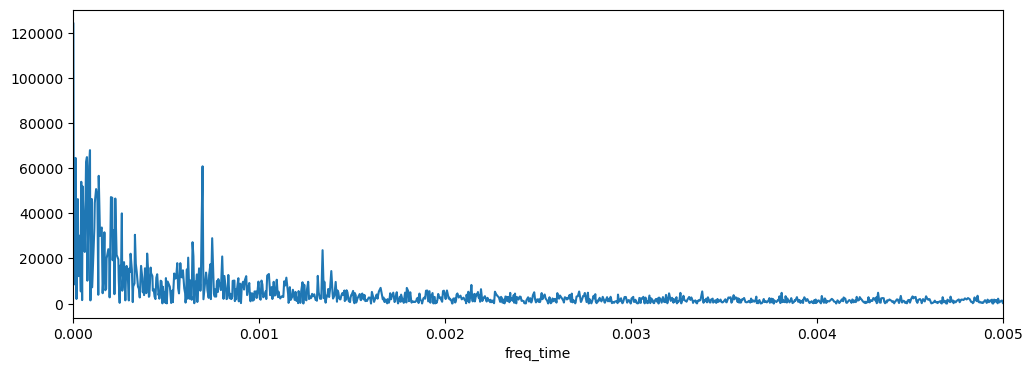

In [170]:
fig = plt.figure(figsize=(12,4))
(u_dft_real).plot()
plt.xlim(0,0.005)

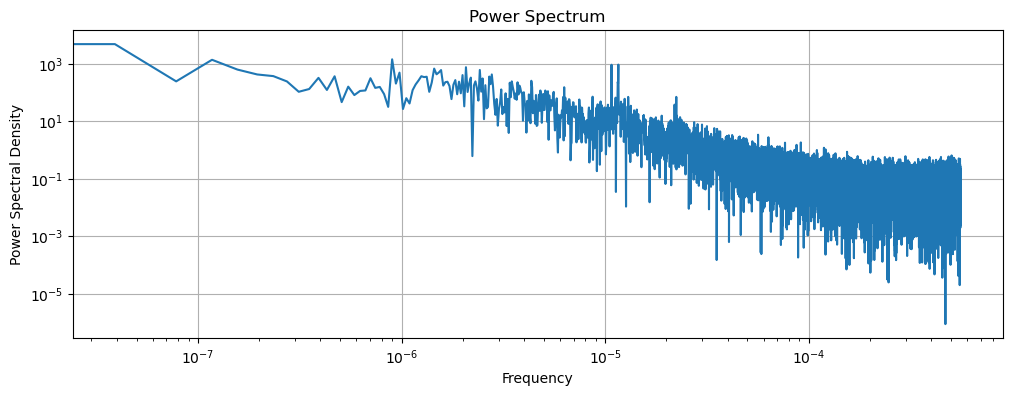

In [58]:
# Compute the PSD
psd = xrft.power_spectrum(east, dim='time')

# Plot the PSD
plt.figure(figsize=(12, 4))
plt.loglog(psd.freq_time, psd)
plt.xlabel('Frequency')
plt.ylabel('Power Spectral Density')
plt.title('Power Spectrum')
plt.grid(True)
plt.show()

## using my functions

In [138]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from scipy import stats
from scipy import signal
from numpy.fft import fft, ifft
from numpy import genfromtxt
from scipy.stats import binned_statistic

def hanning(data,N):
    """
    Create a hanning window filter
    
    Inputs: data - an array (1D timeseries or spatial data),
            N - length of data
    
    Output: data - data array with hanning window applied 
    """
    
    win = np.hanning(N)
    win = np.sqrt(N/(win**2).sum())*win     #why do we have to do this step? 
    data *= win
    
    return data

def calc_freq(N,dt):
    """
    Calculate the frequency of a given dataset
    
    Input: N - number of data points (length of dataset)
           dt - resolution of dataset 
           
    Output: freq - calculated frequency
            scale - scaling factor for frequency
    """
    
    # figure out if data length is even or odd
    # %2 gives you remainder (i.e. if N%2 = 0 then N is even)
    if N%2:
        even = False
    else:
        even = True
        
    # define scaling factor 
    scale = 1/(N*dt)
    
    # get frequency 
    if even:
        freq = np.arange(N/2+1) * scale
    else:
        freq = np.arange((N-1)/2 +1) * scale
        
    return freq, scale

def calc_spectrum(data,scale,N):
    """
    Calculate spectrum using FFT 
    
    Input: data - 1D timeseries or spatial data,
           scale - scaling factor (1/(N*dt))
           N - number of data points (length of data series)
           
    Output: spec - calculated spectrum 
    """
    # calculate FFT of dataset 
    fh = np.fft.rfft(data)
    
    # get spectrum by taking the real part of FFT 
    spec = 2*(fh*fh.conj()).real / scale / N**2
    
    # account for zeroth frequency 
    spec[0] = spec[0]/2
    
    if N%2:
        spec[-1] = spec[-1]/2
        
    return spec
    
    
def spec_var(scale,spec):
    """
    Calculate the variance of the spectrum 
    
    Input: scale - (1/(N*dt))
           spec - spectrum 
           
    Output: spec_var - spectrum variance
    
    """
    
    spec_var = scale*spec[1:].sum()
    
    return spec_var

def get_spectrum(dataset,dt,window=False):
    """
    Calculate the spectrum of a 1D timeseries / spatial series using FFT 
    
    Input: dataset - 1D data series (by time or distance)
    Output: freq - The frequency of the dataset,
            spec - spectrum of the dataset 
    """
    
    data = dataset.copy()
    data = signal.detrend(data)
    
    N = len(data)

    if window == True:
        data = hanning(data,N)
    
    freq,scale = calc_freq(N,dt)
    
    spec = calc_spectrum(data,scale,N)
    
    return freq, spec

In [141]:
freq,spec = get_spectrum(east,15,window=True)

(0.0006, 0.0008)

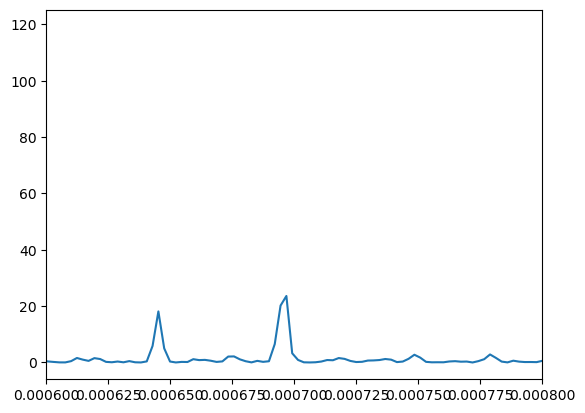

In [146]:
plt.plot(freq,spec)
plt.xlim(0.0006,0.0008)

### starting from scratch with numpy functions 

In [171]:
# step 1: ensure data is even 
# step 2: detrend the data 
tnbd_vel1100.east

<xarray.DataArray 'east' (time: 28610)>
array([-0.045259, -0.057418, -0.051127, ...,  0.025054,  0.026586,  0.024236])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-04T23:59:54

In [173]:
u_detrend = scipy.signal.detrend(tnbd_vel1100.east)

In [174]:
np.fft.rfft(u_detrend)

array([-2.35367281e-13 +0.j        ,  3.70118907e+02-23.07828399j,
       -8.74646875e+01+59.77913946j, ...,  2.03851481e-01 -0.23980061j,
        1.54813531e+00 +0.56291179j, -7.33941656e-01 +0.j        ])

In [196]:
subset = tnbd_vel1100.east.sel(time=slice('2018-03','2019-01-02'))

In [197]:
subset

<xarray.DataArray 'east' (time: 28416)>
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-02T23:45:00

In [198]:
time_strings = subset.time.values

In [199]:
time_strings

array(['2018-03-13T00:00:00.000000000', '2018-03-13T00:15:00.000000000',
       '2018-03-13T00:30:00.000000000', ...,
       '2019-01-02T23:15:00.000000000', '2019-01-02T23:30:00.000000000',
       '2019-01-02T23:45:00.000000000'], dtype='datetime64[ns]')

In [200]:
T = (time_strings[-1] - time_strings[0]).astype('timedelta64[m]')

In [201]:
T

numpy.timedelta64(426225,'m')

In [202]:
T = 426225  #minutes 

In [203]:
delta_t = 15   # minutes 

In [206]:
sample_intervals = T/delta_t

In [207]:
sample_intervals

28415.0

In [208]:
# sample points 
N = sample_intervals + 1 

In [209]:
N

28416.0

In [213]:
nyquist_freq = 1/(2*delta_t)

In [214]:
nyquist_freq

0.03333333333333333

In [212]:
(sample_intervals/2)/(sample_intervals*delta_t)

0.03333333333333333

In [217]:
freq = np.fft.fftfreq(n=len(subset),d=1/15)

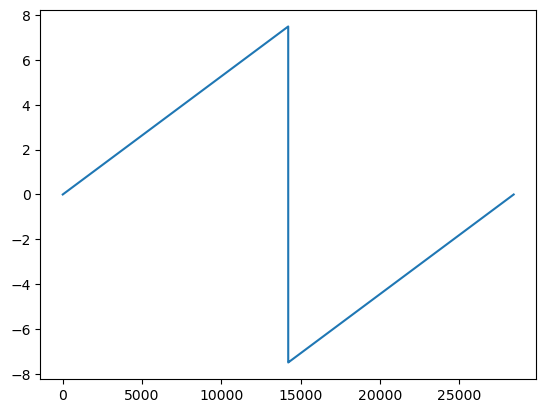

In [218]:
plt.plot(freq)

In [222]:
subset

<xarray.DataArray 'east' (time: 28416)>
array([-0.045259, -0.057418, -0.051127, ...,  0.033375,  0.03174 ,  0.022429])
Coordinates:
    index    (time) int64 ...
  * time     (time) datetime64[ns] 2018-03-13 ... 2019-01-02T23:45:00

In [55]:
freq, spec = scipy.signal.periodogram(east_detrend,1/15,detrend='linear')

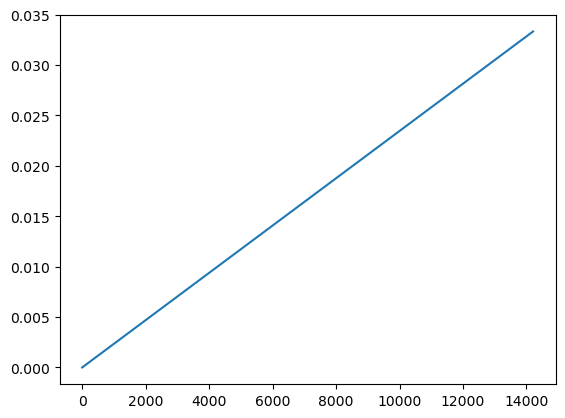

In [60]:
plt.plot(freq)

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

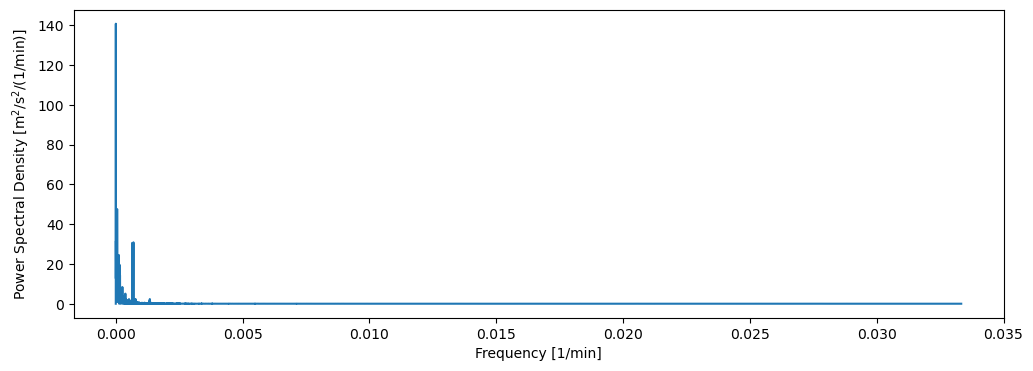

In [56]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

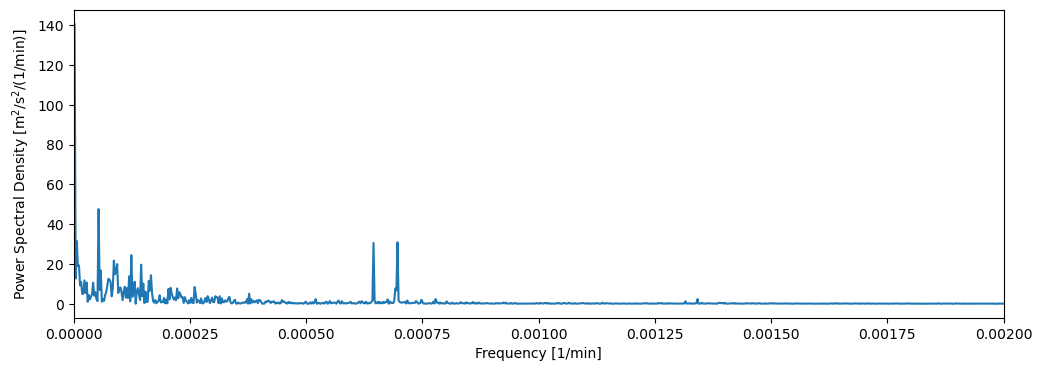

In [57]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0,0.002)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
# wavelet transform 

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

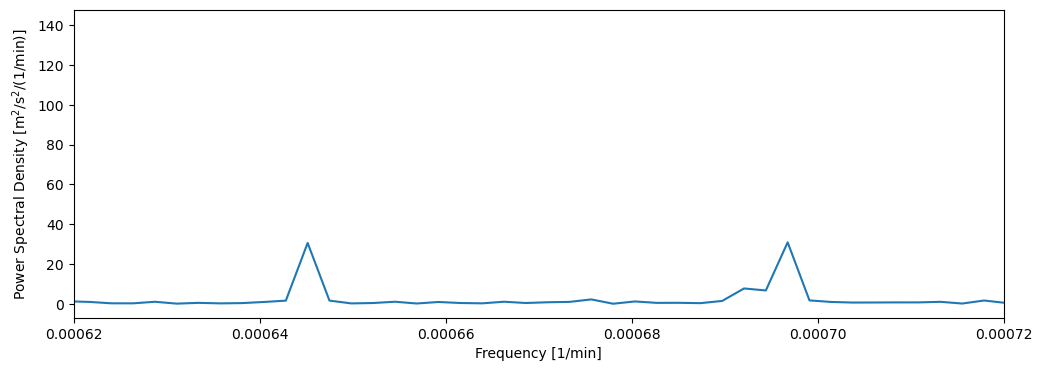

In [58]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0.00062,0.00072)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

(0.0, 20.0)

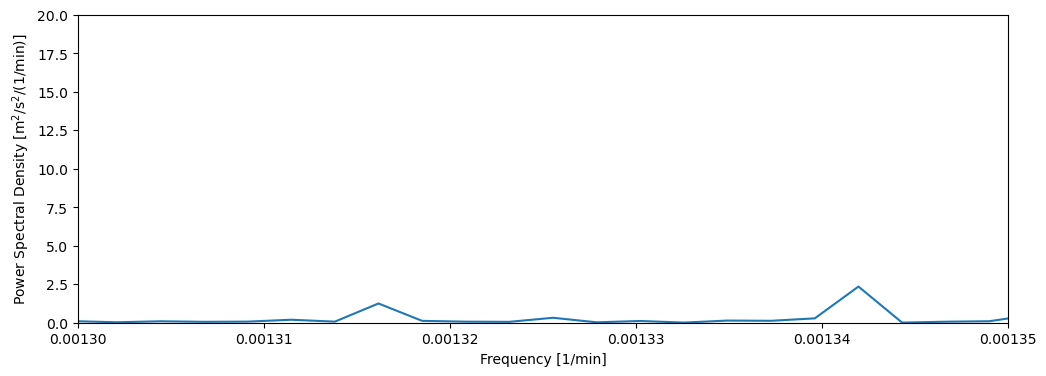

In [59]:
fig = plt.figure(figsize=(12,4))
plt.plot(freq,spec)
plt.xlim(0.00130,0.00135)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
plt.ylim(0,20)

Text(0, 0.5, 'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')

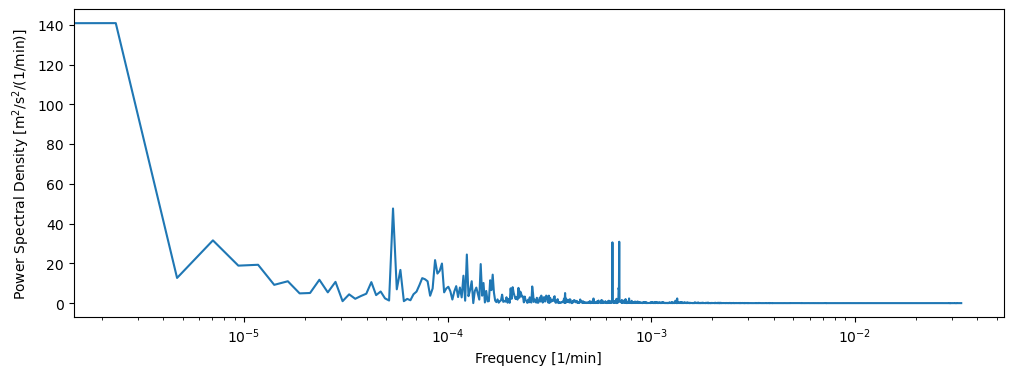

In [236]:
fig = plt.figure(figsize=(12,4))
plt.semilogx(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
# plt.ylim(10e-8,10e2)

(1e-07, 1000.0)

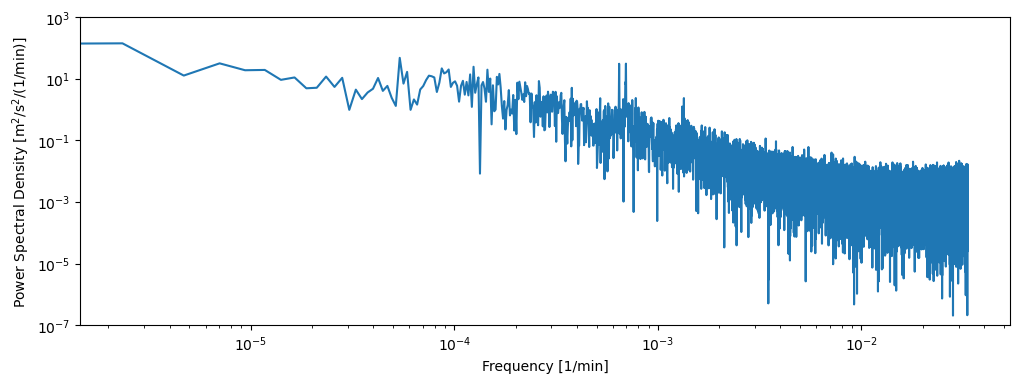

In [235]:
fig = plt.figure(figsize=(12,4))
plt.loglog(freq,spec)
plt.xlabel('Frequency [1/min]')
plt.ylabel(r'Power Spectral Density [m$^{2}$/s$^{2}$/(1/min)]')
plt.ylim(10e-8,10e2)

In [254]:
subset.values

array([-0.04525864, -0.05741761, -0.05112662, ...,  0.03337533,
        0.03173989,  0.02242879])

In [287]:
fft = scipy.fft.fft(subset.values,n=len(subset))

In [288]:
fft 

array([-346.95900729  -0.j        ,  364.40628822-131.08324127j,
        -86.18297815 +14.46482818j, ...,   49.72933276+201.0152511j ,
        -86.18297815 -14.46482818j,  364.40628822+131.08324127j])

In [289]:
len(fft)

28416

In [290]:
fft_real = fft.conj().real

In [291]:
len(fft_real)

28416

In [292]:
len(fft_real[fft_real>0])

13862

In [279]:
fft_real_positive = fft_real[np.where(fft_real >= 0)]

In [280]:
len(fft_real_positive)

13862

In [264]:
fft_freq = scipy.fft.fftfreq(n=len(subset),d=1/15)

In [277]:
len(fft_freq)

28416

In [281]:
fft_freq_positive = fft_freq[np.where(fft_freq >= 0)]

In [286]:
len(fft_freq[fft_freq>0])

14207

In [282]:
len(fft_freq_positive)

14208

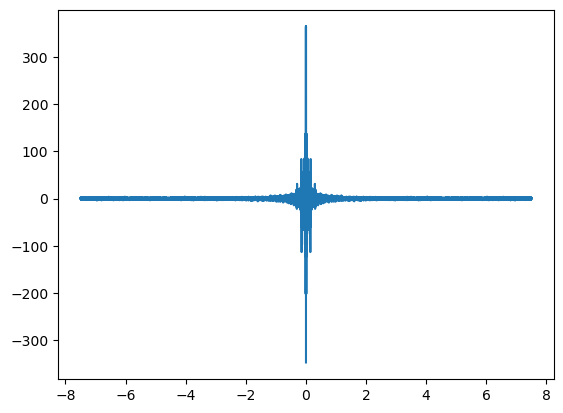

In [293]:
plt.plot(fft_freq,fft_real)